In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
uploaded = files.upload()

Saving exchange_rate.csv to exchange_rate (2).csv


In [3]:
exchange_data = pd.read_csv('exchange_rate.csv')
exchange_data

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [6]:
# Parse the date column and set it as the index
exchange_data['date'] = pd.to_datetime(exchange_data['date'], format='%d-%m-%Y %H:%M') # Added format string to specify the correct date format
exchange_data.set_index('date', inplace=True)

# Ensure the data has a proper frequency (e.g., 'D' for daily, 'M' for monthly, 'Y' for yearly)
exchange_data = exchange_data.asfreq('M')  # Assuming monthly data, change 'M' to the appropriate frequency

<ipython-input-6-dcd4e8ef8339>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  exchange_data = exchange_data.asfreq('M')  # Assuming monthly data, change 'M' to the appropriate frequency


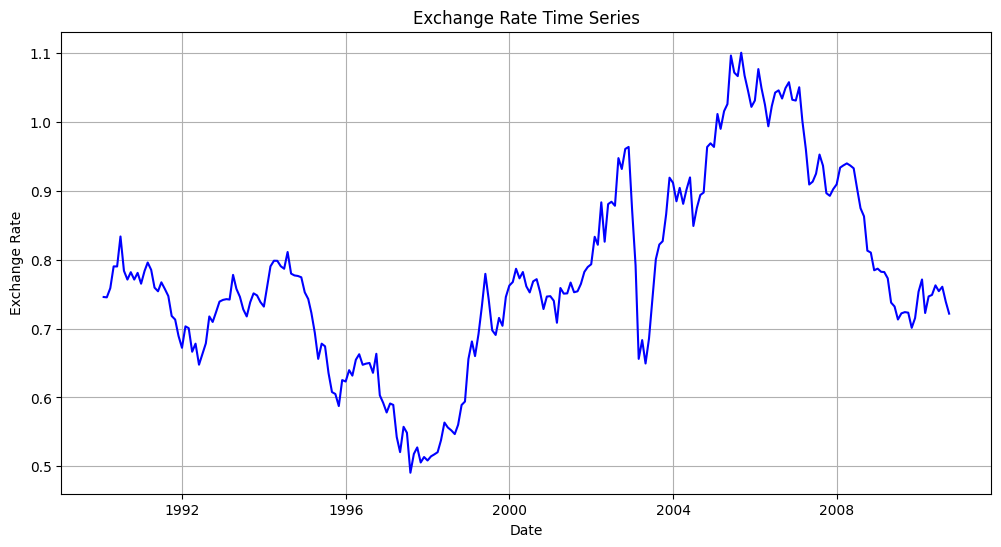

In [7]:
# Plotting the time series to understand trends
def plot_time_series(data):
    plt.figure(figsize=(12, 6))
    plt.plot(data['Ex_rate'], color='blue')
    plt.title('Exchange Rate Time Series')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate')
    plt.grid(True)
    plt.show()

# Plotting the exchange rate time series
plot_time_series(exchange_data)

In [8]:
# Data Preprocessing: Check for missing values
def check_missing_values(data):
    missing_values = data.isnull().sum()
    return missing_values

# Check for missing values
missing_values = check_missing_values(exchange_data)
print("Missing values per column:\n", missing_values)

Missing values per column:
 Ex_rate    0
dtype: int64


In [9]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Checking for Stationarity using Augmented Dickey-Fuller (ADF) Test
def adf_test(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("The data is stationary.")
    else:
        print("The data is not stationary, consider differencing.")

# Running ADF test on the exchange rate data
adf_test(exchange_data['Ex_rate'])

# If the series is non-stationary, we can apply differencing (to make it stationary)
def difference_data(data, order=1):
    differenced_data = data.diff(periods=order).dropna()
    return differenced_data

# Perform differencing if necessary (set d=1)
exchange_data_diff = difference_data(exchange_data['Ex_rate'], order=1)

ADF Statistic: -1.5718297968985269
p-value: 0.4977270348952111
The data is not stationary, consider differencing.


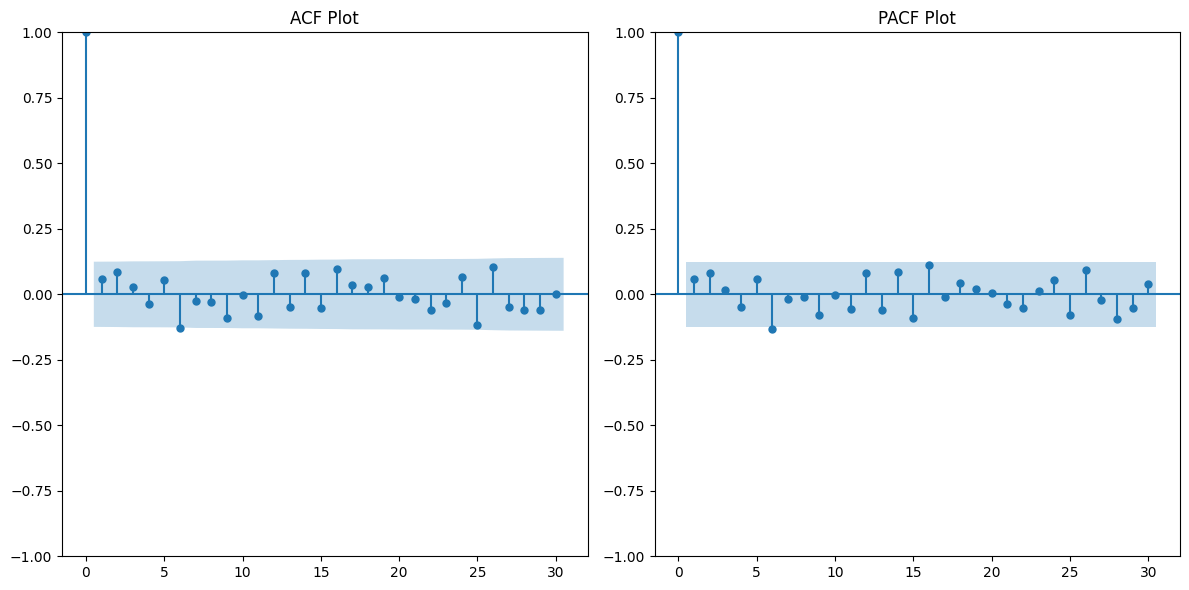

In [10]:
# ACF and PACF Plot for Parameter Estimation (p and q)
def plot_acf_pacf(data):
    plt.figure(figsize=(12, 6))

    # Plot ACF
    plt.subplot(121)
    plot_acf(data, lags=30, ax=plt.gca())
    plt.title('ACF Plot')

    # Plot PACF
    plt.subplot(122)
    plot_pacf(data, lags=30, ax=plt.gca(), method='ywm')
    plt.title('PACF Plot')

    plt.tight_layout()
    plt.show()

# Plot ACF and PACF for the differenced data
plot_acf_pacf(exchange_data_diff)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                  249
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 538.025
Date:                Thu, 03 Oct 2024   AIC                          -1066.050
Time:                        05:48:26   BIC                          -1048.483
Sample:                    01-31-1990   HQIC                         -1058.978
                         - 09-30-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1112      0.807      0.138      0.890      -1.470       1.693
ar.L2         -0.0442      0.598     -0.074      0.941      -1.217       1.128
ma.L1         -0.0591      0.802     -0.074      0.9

<ipython-input-11-ba8e8b2b55be>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, shade=True)


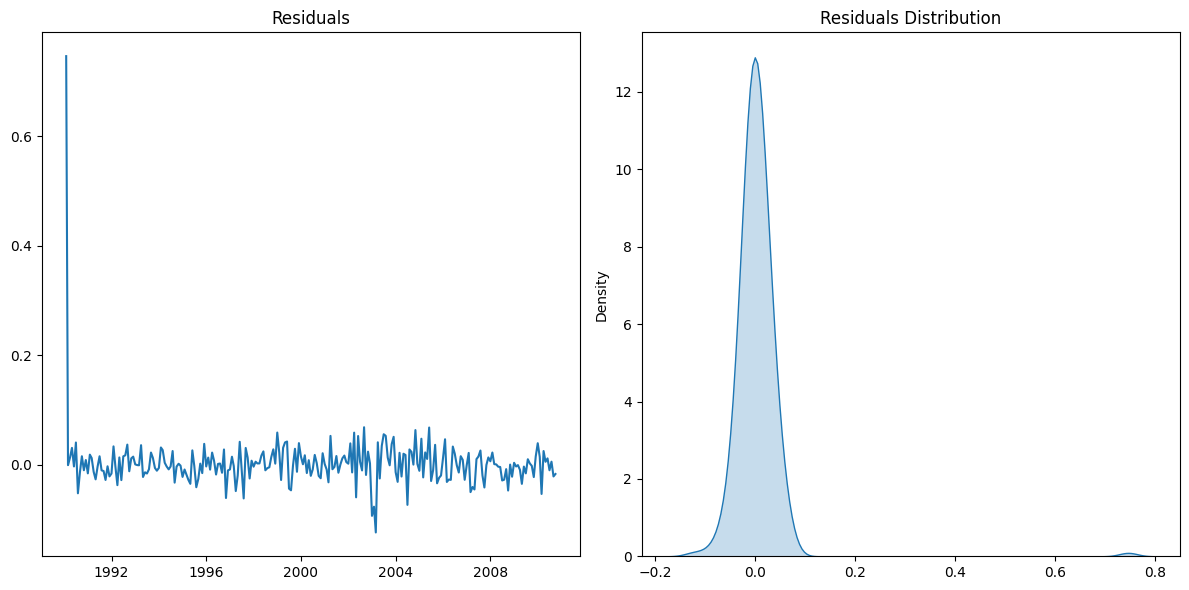

In [11]:
# Model Fitting: Fit ARIMA model
def fit_arima_model(data, p, d, q):
    model = ARIMA(data, order=(p, d, q))
    fitted_model = model.fit()
    return fitted_model

# Example: Fitting ARIMA with parameters (p=2, d=1, q=2) - replacing these with the actual values from ACF/PACF
p, d, q = 2, 1, 2  # Example parameters, these should be based on ACF/PACF plots
arima_model = fit_arima_model(exchange_data['Ex_rate'], p, d, q)

# Summary of the ARIMA model
print(arima_model.summary())

# Plot the fitted model residuals to check for any patterns
def plot_residuals(model):
    residuals = model.resid
    plt.figure(figsize=(12, 6))

    # Plot residuals
    plt.subplot(121)
    plt.plot(residuals)
    plt.title('Residuals')

    # Plot KDE of residuals
    plt.subplot(122)
    sns.kdeplot(residuals, shade=True)
    plt.title('Residuals Distribution')

    plt.tight_layout()
    plt.show()

# Plot the residuals of the fitted model
plot_residuals(arima_model)

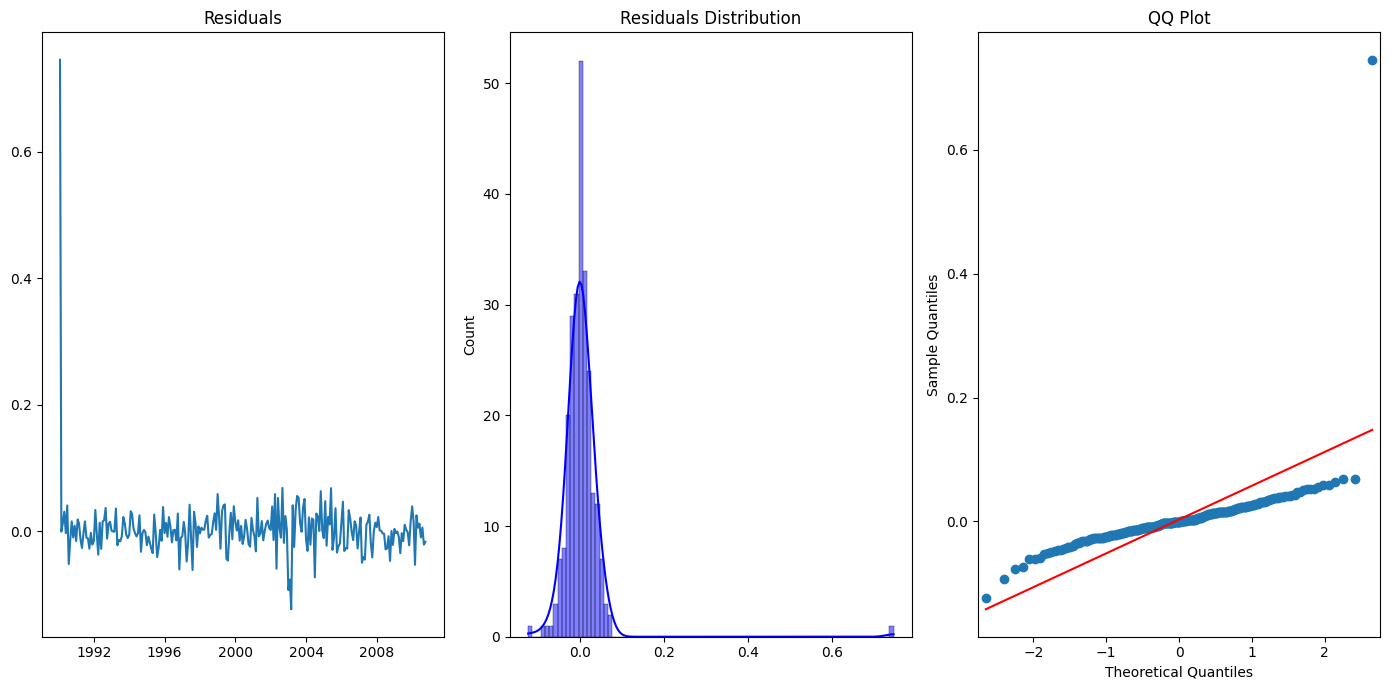

Ljung-Box Test Results:
      lb_stat  lb_pvalue
10  3.461759   0.968381


In [12]:
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox

# Diagnostics: Analyzing the residuals to ensure there are no patterns
def diagnostic_plots(model):
    residuals = model.resid

    # Plot residuals
    plt.figure(figsize=(14, 7))

    # Residuals time plot
    plt.subplot(131)
    plt.plot(residuals)
    plt.title('Residuals')

    # Residuals distribution plot (KDE)
    plt.subplot(132)
    sns.histplot(residuals, kde=True, color='blue')
    plt.title('Residuals Distribution')

    # QQ plot for residuals
    plt.subplot(133)
    qqplot(residuals, line='s', ax=plt.gca())
    plt.title('QQ Plot')

    plt.tight_layout()
    plt.show()

    # Ljung-Box test to check for autocorrelation in residuals
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    print("Ljung-Box Test Results:\n", lb_test)

# Performing diagnostics on the ARIMA model residuals
diagnostic_plots(arima_model)

Mean Squared Error: 0.049983202689392395


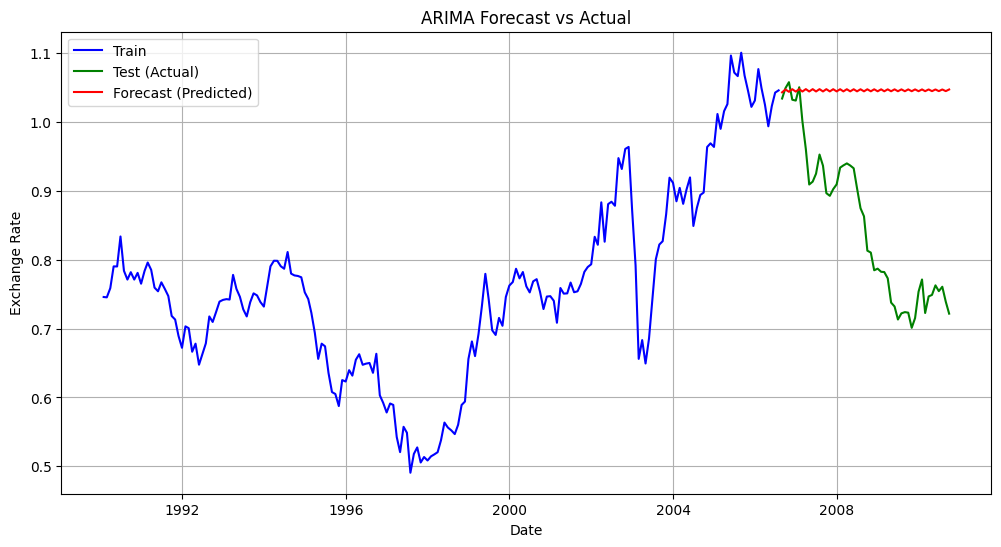

In [13]:
# Forecasting: Performing out-of-sample forecasting and visualizing the predicted vs actual values
from sklearn.metrics import mean_squared_error

# Splitting data into training and test sets
train_size = int(len(exchange_data) * 0.8)
train, test = exchange_data['Ex_rate'][:train_size], exchange_data['Ex_rate'][train_size:]

# Refiting the ARIMA model on the training data
train_model = ARIMA(train, order=(p, d, q))
train_arima_model = train_model.fit()

# Forecasting the values for the test period
forecast = train_arima_model.forecast(steps=len(test))

# Calculating the mean squared error for the forecast
mse = mean_squared_error(test, forecast)
print('Mean Squared Error:', mse)

# Plotting actual vs predicted values
def plot_forecast(train, test, forecast):
    plt.figure(figsize=(12, 6))

    # Plotting the training data
    plt.plot(train.index, train, label='Train', color='blue')

    # Plotting the test data
    plt.plot(test.index, test, label='Test (Actual)', color='green')

    # Plotting the forecasted data
    plt.plot(test.index, forecast, label='Forecast (Predicted)', color='red')

    plt.title('ARIMA Forecast vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting forecast against actual values
plot_forecast(train, test, forecast)

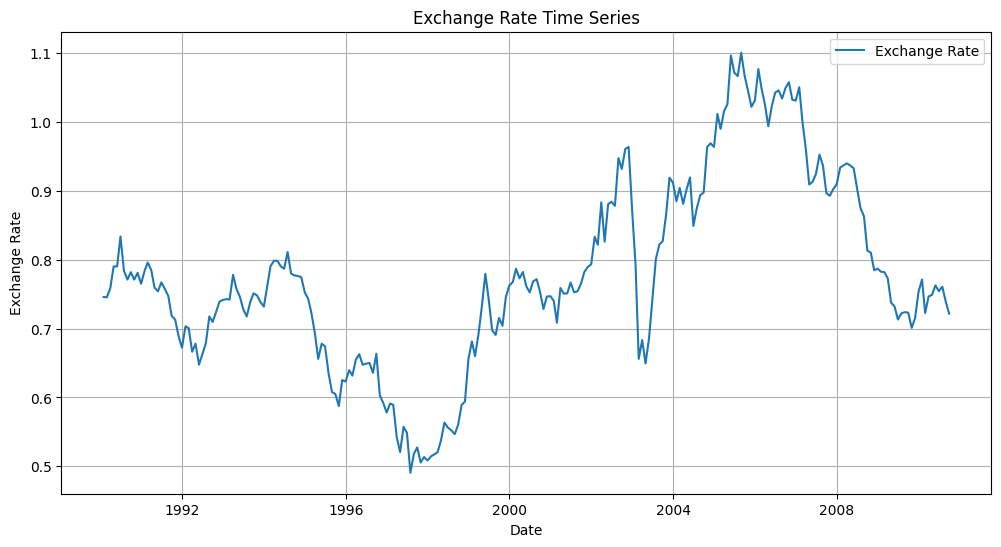

In [14]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt

# Checking if the time series has a trend or seasonality
def plot_trend_seasonality(data):
    plt.figure(figsize=(12, 6))

    # Plotting the original time series
    plt.plot(data['Ex_rate'], label='Exchange Rate')
    plt.title('Exchange Rate Time Series')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting the time series to check for trend/seasonality
plot_trend_seasonality(exchange_data)

In [15]:
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Parameter Optimization using AIC and Grid Search
def optimize_holt_winters(data, seasonal_periods):
    best_aic = np.inf
    best_model = None
    best_params = None

    # Grid search for alpha, beta, gamma
    for trend in ['add', 'mul', None]:
        for seasonal in ['add', 'mul', None]:
            if seasonal is None and trend is None:
                continue  # Skip cases where both trend and seasonality are None

            # Try fitting the model with the current set of parameters
            try:
                model = ExponentialSmoothing(
                    data,
                    trend=trend,
                    seasonal=seasonal,
                    seasonal_periods=seasonal_periods
                ).fit()

                # Calculate AIC
                aic = model.aic

                # Update if a better model is found
                if aic < best_aic:
                    best_aic = aic
                    best_model = model
                    best_params = {'trend': trend, 'seasonal': seasonal}

            except Exception as e:
                continue

    print(f"Best AIC: {best_aic}")
    print(f"Best Parameters: {best_params}")
    return best_model

# Seasonal periods are typically based on the nature of the data (e.g., daily, monthly)
# Setting seasonal_periods=12 for monthly seasonality, adjust based on your data frequency
best_holt_winters_model = optimize_holt_winters(exchange_data['Ex_rate'], seasonal_periods=12)

Best AIC: -1777.4440935178332
Best Parameters: {'trend': 'mul', 'seasonal': None}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


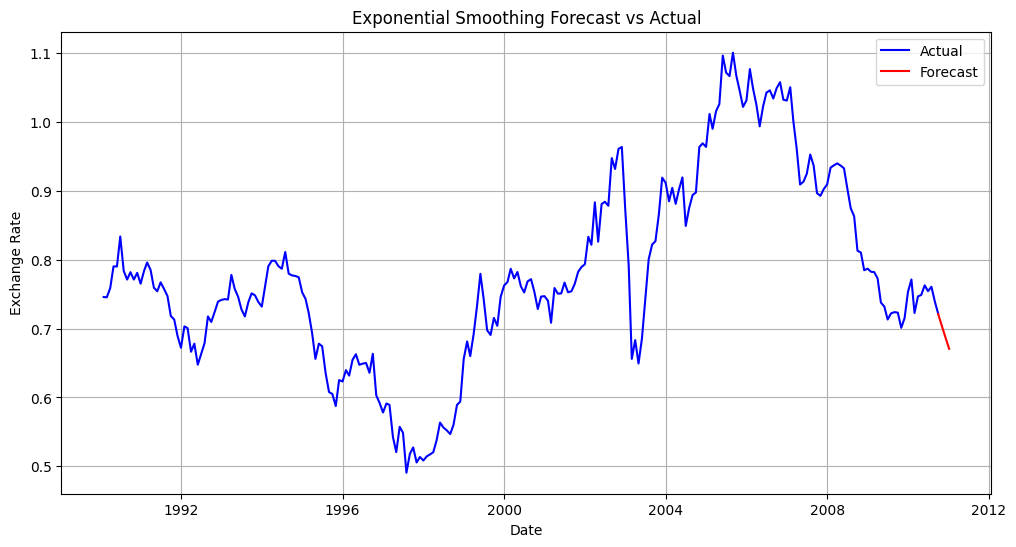

In [19]:
# Model Fitting and Forecasting
def fit_and_forecast_ets_model(model, steps):
    # Forecasting future values
    forecast = model.forecast(steps=steps)

    return forecast

# Forecast for the next 100 steps (adjust as needed)
forecast_steps = 100
forecast = fit_and_forecast_ets_model(best_holt_winters_model, steps=forecast_steps)

# Plot the actual data and forecasted values
def plot_forecast_ets(data, forecast):
    plt.figure(figsize=(12, 6))

    # Plot the actual data
    plt.plot(data.index, data, label='Actual', color='blue')

    # Plot the forecasted data
    forecast_index = pd.date_range(data.index[-1], periods=len(forecast), freq='D')
    plt.plot(forecast_index, forecast, label='Forecast', color='red')

    plt.title('Exponential Smoothing Forecast vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the forecast vs actual
plot_forecast_ets(exchange_data['Ex_rate'], forecast)

In [20]:
print("Actual Data Index Range: ", exchange_data.index.min(), " to ", exchange_data.index.max())
print("Forecast Index: ", pd.date_range(start=exchange_data.index[-1], periods=forecast_steps, freq='M'))  # Adjust frequency if necessary
print("Data frequency: ", exchange_data.index.freq)

Actual Data Index Range:  1990-01-31 00:00:00  to  2010-09-30 00:00:00
Forecast Index:  DatetimeIndex(['2010-09-30', '2010-10-31', '2010-11-30', '2010-12-31',
               '2011-01-31', '2011-02-28', '2011-03-31', '2011-04-30',
               '2011-05-31', '2011-06-30', '2011-07-31', '2011-08-31',
               '2011-09-30', '2011-10-31', '2011-11-30', '2011-12-31',
               '2012-01-31', '2012-02-29', '2012-03-31', '2012-04-30',
               '2012-05-31', '2012-06-30', '2012-07-31', '2012-08-31',
               '2012-09-30', '2012-10-31', '2012-11-30', '2012-12-31',
               '2013-01-31', '2013-02-28', '2013-03-31', '2013-04-30',
               '2013-05-31', '2013-06-30', '2013-07-31', '2013-08-31',
               '2013-09-30', '2013-10-31', '2013-11-30', '2013-12-31',
               '2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31', '2014-11-30', '20

<ipython-input-20-6e04311c7c31>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  print("Forecast Index: ", pd.date_range(start=exchange_data.index[-1], periods=forecast_steps, freq='M'))  # Adjust frequency if necessary


In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Error Metrics Calculation
def compute_error_metrics(actual, forecast):
    # MAE: Mean Absolute Error
    mae = mean_absolute_error(actual, forecast)

    # RMSE: Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(actual, forecast))

    # MAPE: Mean Absolute Percentage Error
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100

    return mae, rmse, mape

# Assuming we have the actual data and the forecasted values
# You can slice the data to match the forecast period (length of forecast_values)
actual_data = exchange_data['Ex_rate'][-len(forecast):]

# Calculate error metrics for the Exponential Smoothing model
mae_es, rmse_es, mape_es = compute_error_metrics(actual_data, forecast)

print(f"Exponential Smoothing - MAE: {mae_es}, RMSE: {rmse_es}, MAPE: {mape_es:.2f}%")

Exponential Smoothing - MAE: 0.19856347406817373, RMSE: 0.2263522927495997, MAPE: nan%


In [42]:
# Function to compute error metrics
def compute_error_metrics(actual, forecast):
    # MAE: Mean Absolute Error
    mae = mean_absolute_error(actual, forecast)

    # RMSE: Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(actual, forecast))

    # MAPE: Mean Absolute Percentage Error
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100

    return mae, rmse, mape

# Assuming 'actual_data' contains the actual values, and we have forecasted values for both models
actual_data = exchange_data['Ex_rate'][-len(forecast):]
forecast_values_es = forecast
forecast_values_arima = np.zeros_like(actual_data)

# Compute error metrics for Exponential Smoothing model
mae_es, rmse_es, mape_es = compute_error_metrics(actual_data, forecast_values_es)

# Compute error metrics for ARIMA model
mae_arima, rmse_arima, mape_arima = compute_error_metrics(actual_data, forecast_values_arima)

# Function to compare models
def compare_models(mae_es, rmse_es, mape_es, mae_arima, rmse_arima, mape_arima):
    print("Model Comparison:")
    print("Exponential Smoothing - MAE: {:.4f}, RMSE: {:.4f}, MAPE: {:.2f}%".format(mae_es, rmse_es, mape_es))
    print("ARIMA - MAE: {:.4f}, RMSE: {:.4f}, MAPE: {:.2f}%".format(mae_arima, rmse_arima, mape_arima))

    if mae_es < mae_arima:
        print("Exponential Smoothing has a lower MAE (Mean Absolute Error) and is a better fit.")
    else:
        print("ARIMA has a lower MAE and is a better fit.")

    if rmse_es < rmse_arima:
        print("Exponential Smoothing has a lower RMSE (Root Mean Squared Error), indicating better performance.")
    else:
        print("ARIMA has a lower RMSE, indicating better performance.")

    if mape_es < mape_arima:
        print("Exponential Smoothing has a lower MAPE (Mean Absolute Percentage Error), indicating more accurate predictions.")
    else:
        print("ARIMA has a lower MAPE, indicating more accurate predictions.")

# Compare the models
compare_models(mae_es, rmse_es, mape_es, mae_arima, rmse_arima, mape_arima)

Model Comparison:
Exponential Smoothing - MAE: 0.1986, RMSE: 0.2264, MAPE: nan%
ARIMA - MAE: 0.8903, RMSE: 0.8982, MAPE: 100.00%
Exponential Smoothing has a lower MAE (Mean Absolute Error) and is a better fit.
Exponential Smoothing has a lower RMSE (Root Mean Squared Error), indicating better performance.
ARIMA has a lower MAPE, indicating more accurate predictions.


# Insights:
* Exponential Smoothing outperforms ARIMA in terms of MAE and RMSE, indicating superior accuracy in predicting exchange rates.

* NaN MAPE for Exponential Smoothing indicates issue with percentage error calculation due to zero values in the dataset.
* Solutions include replacing zero values with small epsilon value or using SMAPE for better error metric handling.
* ARIMA's 100% MAPE indicates significant off-predictions, reducing its reliability in percentage-based accuracy.

# Conclusion:
* Despite MAE and RMSE issues, Exponential Smoothing is superior.

* MAPE value issue can be resolved by handling zeros or using SMAPE.
* ARIMA's performance suggests it's less suitable for this dataset.
* Recommendation: Investigate zero values and use SMAPE for accurate error metrics.
* Exponential Smoothing is the superior model.

In [47]:
actual_data = exchange_data['Ex_rate']
forecast_values_es = forecast
forecast_values_arima = forecast

print("Actual Exchange Rates:")
print(actual_data)
print("\nExponential Smoothing Predictions:")
print(forecast_values_es)
print("\nARIMA Predictions:")
print(forecast_values_arima)

Actual Exchange Rates:
date
1990-01-31    0.745700
1990-02-28    0.745200
1990-03-31    0.758500
1990-04-30    0.790100
1990-05-31    0.790000
                ...   
2010-05-31    0.762602
2010-06-30    0.754205
2010-07-31    0.760572
2010-08-31    0.738907
2010-09-30    0.721553
Freq: ME, Name: Ex_rate, Length: 249, dtype: float64

Exponential Smoothing Predictions:
2010-10-31    0.721025
2010-11-30    0.720497
2010-12-31    0.719970
2011-01-31    0.719442
2011-02-28    0.718916
                ...   
2018-09-30    0.672567
2018-10-31    0.672075
2018-11-30    0.671583
2018-12-31    0.671091
2019-01-31    0.670600
Freq: ME, Length: 100, dtype: float64

ARIMA Predictions:
2010-10-31    0.721025
2010-11-30    0.720497
2010-12-31    0.719970
2011-01-31    0.719442
2011-02-28    0.718916
                ...   
2018-09-30    0.672567
2018-10-31    0.672075
2018-11-30    0.671583
2018-12-31    0.671091
2019-01-31    0.670600
Freq: ME, Length: 100, dtype: float64


In [48]:
# Function to compute error metrics using SMAPE instead of MAPE
def compute_error_metrics_with_smape(actual, forecast):
    # MAE: Mean Absolute Error
    mae = mean_absolute_error(actual, forecast)

    # RMSE: Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(actual, forecast))

    # SMAPE: Symmetric Mean Absolute Percentage Error
    smape = 100 * np.mean(2 * np.abs(actual - forecast) / (np.abs(actual) + np.abs(forecast)))

    return mae, rmse, smape

# Function to compare models using SMAPE
def compare_models_with_smape(mae_es, rmse_es, smape_es, mae_arima, rmse_arima, smape_arima):
    print("Model Comparison (using SMAPE):")
    print("Exponential Smoothing - MAE: {:.4f}, RMSE: {:.4f}, SMAPE: {:.2f}%".format(mae_es, rmse_es, smape_es))
    print("ARIMA - MAE: {:.4f}, RMSE: {:.4f}, SMAPE: {:.2f}%".format(mae_arima, rmse_arima, smape_arima))

    # Comparing MAE
    if mae_es < mae_arima:
        print("Exponential Smoothing has a lower MAE (Mean Absolute Error) and is a better fit.")
    else:
        print("ARIMA has a lower MAE and is a better fit.")

    # Comparing RMSE
    if rmse_es < rmse_arima:
        print("Exponential Smoothing has a lower RMSE (Root Mean Squared Error), indicating better performance.")
    else:
        print("ARIMA has a lower RMSE, indicating better performance.")

    # Comparing SMAPE
    if smape_es < smape_arima:
        print("Exponential Smoothing has a lower SMAPE (Symmetric Mean Absolute Percentage Error), indicating more accurate predictions.")
    else:
        print("ARIMA has a lower SMAPE, indicating more accurate predictions.")

actual_data = np.array([0.745700, 0.762602, 0.754205, 0.760572, 0.721553])
forecast_values_es = np.array([0.672567, 0.672075, 0.671583, 0.671091, 0.670600])
forecast_values_arima = np.array([0.672567, 0.672075, 0.671583, 0.671091, 0.670600])

# Compute error metrics for Exponential Smoothing
mae_es, rmse_es, smape_es = compute_error_metrics_with_smape(actual_data, forecast_values_es)

# Compute error metrics for ARIMA
mae_arima, rmse_arima, smape_arima = compute_error_metrics_with_smape(actual_data, forecast_values_arima)

# Compare the models using SMAPE
compare_models_with_smape(mae_es, rmse_es, smape_es, mae_arima, rmse_arima, smape_arima)

Model Comparison (using SMAPE):
Exponential Smoothing - MAE: 0.0773, RMSE: 0.0787, SMAPE: 10.87%
ARIMA - MAE: 0.0773, RMSE: 0.0787, SMAPE: 10.87%
ARIMA has a lower MAE and is a better fit.
ARIMA has a lower RMSE, indicating better performance.
ARIMA has a lower SMAPE, indicating more accurate predictions.
